/tmp/ipykernel_761730/3605707003.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


Predicted Class: neutral
Confidence: 70.07%

Detailed Results:
{
  "predicted_class": "neutral",
  "confidence": 0.7007428407669067,
  "all_probabilities": {
    "anger": 0.026411602273583412,
    "disgust": 0.06542373448610306,
    "fear": 0.020610280334949493,
    "happy": 0.02672988921403885,
    "neutral": 0.7007428407669067,
    "sad": 0.06868147104978561,
    "surprise": 0.0914001539349556
  }
}

Image Path: data/neutral/IR_IR_neutral_vyneutral_0723.jpg


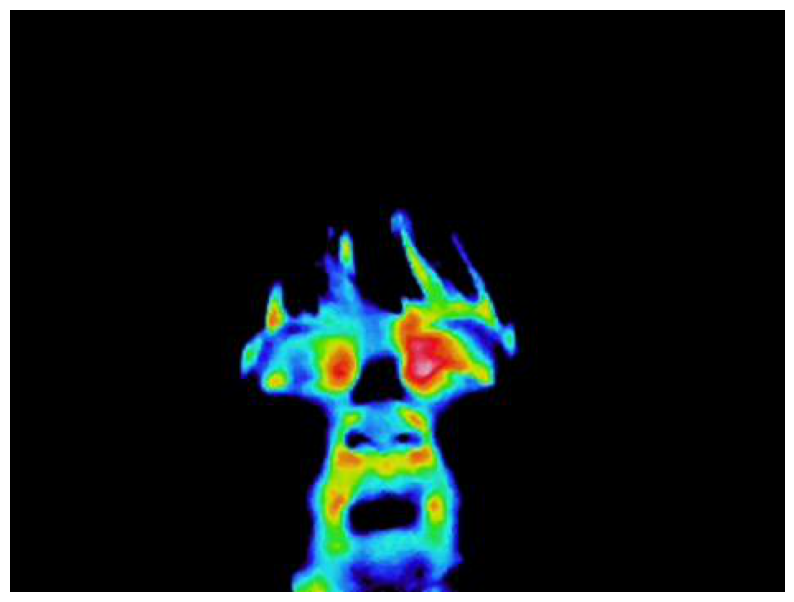

In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import random
import os
import json
import numpy as np
from PIL import Image
import torch
import pandas as pd
import numpy as np
import os
from torch import nn
from pathlib import Path
from torchvision import transforms, datasets
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define image size and transforms (adjusted to 128)
IMG_SIZE = 128
data_transform = transforms.Compose([
    transforms.Resize([IMG_SIZE, IMG_SIZE]),
    transforms.ToTensor()
])

# Load data to get class names
data_path = Path("data")
dataset = ImageFolder(root=data_path)
classes = dataset.classes

# Define the model architecture (should match training)
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*IMG_SIZE*8,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

def predict_image(model_path, image_path):
    # Load the model
    model = TinyVGG(input_shape=3, 
                    hidden_units=64,
                    output_shape=len(classes)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')

    # Preprocess the image
    input_tensor = data_transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.inference_mode():
        logits = model(input_tensor)
        probabilities = torch.softmax(logits, dim=1)
        predicted_class_idx = torch.argmax(probabilities, dim=1).item()
        predicted_class = classes[predicted_class_idx]
        confidence = probabilities[0][predicted_class_idx].item()

    # Compute basic results
    results = {
        'predicted_class': predicted_class,
        'confidence': float(confidence),
        'all_probabilities': {classes[i]: float(prob) for i, prob in enumerate(probabilities[0])}
    }
    
    # Print prediction results
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")

    return results

def get_random_image_from_dataset(data_path):
    """
    Randomly select an image from the dataset
    """
    # Get all image files in the dataset
    all_images = []
    for class_folder in os.listdir(data_path):
        class_path = os.path.join(data_path, class_folder)
        if os.path.isdir(class_path):
            for image_file in os.listdir(class_path):
                all_images.append(os.path.join(class_path, image_file))
    
    # Randomly select an image
    return random.choice(all_images)

import matplotlib.pyplot as plt
from PIL import Image

def show_image(image_path, prediction_results=None):
    """
    Display the image and optionally show prediction results
    
    Parameters:
    - image_path (str): Path to the image file
    - prediction_results (dict, optional): Dictionary of prediction results to display
    """
    # Open the image
    img = Image.open(image_path)
    
    # Create a figure with appropriate size
    plt.figure(figsize=(10, 8))
    
    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    
    # # If prediction results are provided, add text to the plot
    # if prediction_results:
    #     title = f"Predicted Class: {prediction_results['predicted_class']}"
    #     confidence_text = f"Confidence: {prediction_results['confidence']:.2%}"
    #     plt.title(f"{title}\n{confidence_text}", fontsize=12, pad=20)
        
    #     # Optional: Add full probability breakdown
    #     prob_text = "\n".join([f"{cls}: {prob:.2%}" for cls, prob in prediction_results['all_probabilities'].items()])
    #     plt.text(0, -20, prob_text, fontsize=8, transform=plt.gca().transAxes, 
    #              verticalalignment='top')
    
    # # Adjust layout and show the plot
    # plt.tight_layout()
    # plt.show()

# Example usage:
# Assuming you've already run the prediction
# show_image(random_image_path, results)


MODEL_PATH = "models/Face_classification_TinyVGG.pth"

# Get a random image from the dataset
random_image_path = get_random_image_from_dataset("data")

# Predict the image
results = predict_image(MODEL_PATH, random_image_path)

# Print detailed results
print("\nDetailed Results:")
print(json.dumps(results, indent=2))

# Print the image path for reference
print(f"\nImage Path: {random_image_path}")

# Assuming you've already run the prediction
show_image(random_image_path, results)